# Capstone 2

## Polish Bankruptcy

## Modeling

In the pre-processing notebook, the logistic regression had high accuracy in predicting bankruptcy but resulted in very low recall.  In this notebook, I will apply resampling techniques to improve recall.  I will use both oversampling the minority class and undersampling the majority class on the logistic regression model and apply two other models with and without both resampling methods.  After doing the resampling I will then do hperparameter tuning on all three models with and on the raw data and the oversampled and undersampled data.  I will then compare the results from the classification reports for each process and evaluate the results. 

## Import Statements

In [126]:
#import all needed packages

import pandas as pd
import numpy as np
import os
import time

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
import shap
from sklearn.inspection import permutation_importance

## Load Data

In [2]:
# timer object to measure processing time
start = time.time()

# load the train test files from disk
filename = 'X_train_scaled.csv'
X_train = pd.read_csv('X_train_scaled.csv', index_col=0)
X_test = pd.read_csv('X_test_scaled.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

I have chosen to use SMOTE oversampling on the training data and Random undersampling for my resampling techniques.

## Oversample data with SMOTE

In [3]:
#resample the training data with SMOTE
smote_resamp = SMOTE(sampling_strategy='minority')
X_train_resamp, y_train_resamp = smote_resamp.fit_resample(X_train, y_train)

## Undersample data with Random undersample

In [4]:
#resample the traing data with Random undersampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In the next section I am printing out the imported data to verify it imported correctly as well as the resampled data.

## View Train Test Data

In [5]:
#print scaled data
print(X_train)

            X02       X03       X04       X08       X09       X10       X11  \
12113  0.127666 -0.163551 -0.019446 -0.025616 -0.037721 -0.073549 -0.339471   
3289  -0.053666  0.028093 -0.014577 -0.019986 -0.035235  0.009176 -0.032724   
16567 -0.007887 -0.039875 -0.018477 -0.023735 -0.034676 -0.014012 -0.033221   
21367 -0.006966  0.046737 -0.012777 -0.023654 -0.031725 -0.011934 -0.003059   
32394 -0.077769  0.085720 -0.000891 -0.010024 -0.030893  0.020583  0.006298   
...         ...       ...       ...       ...       ...       ...       ...   
24299  0.249851 -0.139514 -0.019874 -0.026012 -0.031294 -0.124618 -0.342898   
41350 -0.025706  0.029824 -0.015768 -0.022830 -0.032927 -0.004345  0.003568   
38703 -0.006487  0.011172 -0.014978 -0.023610 -0.030218 -0.010802  0.002055   
12352 -0.070602  0.067679 -0.004315 -0.014995 -0.035090  0.017666  0.006355   
24962  0.016042 -0.061004 -0.019018 -0.024267  0.094182 -0.020805 -0.022322   

            X12       X13       X14  ...       X50 

In [6]:
#print resampled data
print(X_train_resamp)

            X02       X03       X04       X08       X09       X10       X11  \
0      0.127666 -0.163551 -0.019446 -0.025616 -0.037721 -0.073549 -0.339471   
1     -0.053666  0.028093 -0.014577 -0.019986 -0.035235  0.009176 -0.032724   
2     -0.007887 -0.039875 -0.018477 -0.023735 -0.034676 -0.014012 -0.033221   
3     -0.006966  0.046737 -0.012777 -0.023654 -0.031725 -0.011934 -0.003059   
4     -0.077769  0.085720 -0.000891 -0.010024 -0.030893  0.020583  0.006298   
...         ...       ...       ...       ...       ...       ...       ...   
61965  0.009312  0.019644 -0.016467 -0.024093 -0.005884 -0.017814  0.051926   
61966 -0.029454 -0.012061 -0.017310 -0.022569 -0.036565 -0.002404 -0.056163   
61967  0.021680  0.014807 -0.015966 -0.024387 -0.018788 -0.023316 -0.021810   
61968  0.061963 -0.040962 -0.018068 -0.025015 -0.022907 -0.041217 -0.022790   
61969  0.031600 -0.038521 -0.018522 -0.024564 -0.034657 -0.028625 -0.068738   

            X12       X13       X14  ...       X50 

In [7]:
#print resampled data
print(X_train_rus)

           X02       X03       X04       X08       X09       X10       X11  \
0    -0.083566 -0.003799 -0.013743 -0.008840 -0.031901  0.002128  0.152494   
1    -0.084440  0.034916  0.000951  0.001084 -0.027211  0.023810  0.026434   
2    -0.046389 -0.004642 -0.016810 -0.020939 -0.033088  0.006915  0.001359   
3    -0.080982  0.102585  0.006406 -0.005989 -0.054285  0.022275  0.023296   
4    -0.007773  0.022419 -0.015917 -0.023562 -0.020903 -0.010231 -0.022309   
...        ...       ...       ...       ...       ...       ...       ...   
3131 -0.088789  0.090873  0.033157  0.021884 -0.031488  0.025766 -0.028064   
3132  0.000708 -0.006364 -0.017308 -0.023853  0.011853 -0.013996 -0.020567   
3133  0.044640 -0.071472 -0.018703 -0.024795  0.078539 -0.033498 -0.000468   
3134 -0.013576 -0.028054 -0.017998 -0.023327 -0.033749 -0.007654  0.001809   
3135 -0.028781  0.081958 -0.013535 -0.022517 -0.012355 -0.000903 -0.115498   

           X12       X13       X14  ...       X50       X51    

In [8]:
#print scaled test data
print(X_test)

            X02       X03       X04       X08       X09       X10       X11  \
25162 -0.039049 -0.025318 -0.018181 -0.022973 -0.035122 -0.013729 -0.035424   
15362 -0.057620  0.047476 -0.012828 -0.019149 -0.010805  0.011902  0.046414   
4236  -0.054234  0.025213 -0.014726 -0.019909 -0.032972  0.009232 -0.006364   
33893  0.024996 -0.023946 -0.017795 -0.024459 -0.029464 -0.024780 -0.019124   
40333 -0.056477 -0.003534 -0.016555 -0.019379 -0.016365  0.011394 -0.033572   
...         ...       ...       ...       ...       ...       ...       ...   
10939  0.016483 -0.054493 -0.018889 -0.024627 -0.028996 -0.030689 -0.027983   
9520   0.059796 -0.119205 -0.019455 -0.024996 -0.025208 -0.040232 -0.008556   
41847 -0.020024  0.023409 -0.015848 -0.023235 -0.034940 -0.008716 -0.035046   
38614 -0.012248 -0.032429 -0.018466 -0.023559 -0.034684 -0.011841 -0.040633   
33968 -0.040515  0.010662 -0.015448 -0.023110 -0.034938 -0.016339 -0.031364   

            X12       X13       X14  ...       X50 

In [9]:
#print y train data
print(y_train)

       Class
12113      0
3289       0
16567      0
21367      0
32394      0
...      ...
24299      0
41350      0
38703      0
12352      0
24962      0

[32553 rows x 1 columns]


In [10]:
#print resampled training data
print(y_train_resamp)

       Class
0          0
1          0
2          0
3          0
4          0
...      ...
61965      1
61966      1
61967      1
61968      1
61969      1

[61970 rows x 1 columns]


In [11]:
# print resampled training data
print(y_train_rus)

      Class
0         0
1         0
2         0
3         0
4         0
...     ...
3131      1
3132      1
3133      1
3134      1
3135      1

[3136 rows x 1 columns]


In [12]:
#print y test data
print(y_test)

       Class
25162      0
15362      0
4236       0
33893      0
40333      0
...      ...
10939      0
9520       0
41847      0
38614      0
33968      0

[10852 rows x 1 columns]


In the following section I with run Logistic Regression, Random Forest and XGB on the original data as well as the oversampled and undersampled data.  After each technique I will print out the accuracy and the classification report obtained from each which will be summarized in a table below.

## Create Logistic Regression object

In [13]:
# create the regression object
clf1 = LogisticRegression(max_iter=1000)
# fit the scaled and training data
clf1.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=1000)

In [14]:
# run the regression model
y_test_pred_lr1 = clf1.predict(X_test)
y_train_pred_lr1 = clf1.predict(X_train)

## Print Logistic Accuracy

In [15]:
# print test accuracy
accuracy = accuracy_score(y_test, y_test_pred_lr1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.16%


## Print Logistic Classification

In [16]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_lr1))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     10329
           1       0.40      0.01      0.02       523

    accuracy                           0.95     10852
   macro avg       0.68      0.50      0.50     10852
weighted avg       0.93      0.95      0.93     10852



## Logistic Regression on Oversampled data

In [17]:
#create the LR object
clf2 = LogisticRegression(max_iter=1000)
# fit the scaled and training data
clf2.fit(X_train_resamp, y_train_resamp.values.ravel())

LogisticRegression(max_iter=1000)

In [18]:
#predict on the test data
y_test_pred_lr2 = clf2.predict(X_test)
y_train_pred_lr2 = clf2.predict(X_train_resamp)

## Accuracy of Oversampled data

In [19]:
# print test accuracy
accuracy = accuracy_score(y_test, y_test_pred_lr2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.73%


## Classification Report of Oversampled data

In [20]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_lr2))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     10329
           1       0.09      0.63      0.16       523

    accuracy                           0.69     10852
   macro avg       0.53      0.66      0.48     10852
weighted avg       0.93      0.69      0.78     10852



## Logistic Regression of Undersampled data

In [21]:
#create the LR object 
clf3 = LogisticRegression(max_iter=1000)
# fit the scaled and training data
clf3.fit(X_train_rus, y_train_rus.values.ravel())

LogisticRegression(max_iter=1000)

In [22]:
#predict on the test data
y_test_pred_lr3 = clf3.predict(X_test)
y_train_pred_lr3 = clf3.predict(X_train_rus)

## Accuracy of Undersampled data

In [23]:
# print test accuracy
accuracy = accuracy_score(y_test, y_test_pred_lr3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.75%


## Classification Report of Undersampled data

In [24]:
# print classification report
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_lr3))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.70      0.82     10329
           1       0.09      0.60      0.16       523

    accuracy                           0.70     10852
   macro avg       0.53      0.65      0.49     10852
weighted avg       0.93      0.70      0.78     10852



## Create XGB Object

In [25]:
#create XGB object
xgb1 = XGBClassifier()
xgb1.fit(X_train, y_train.values.ravel())

# predict on test data
y_test_pred_xgb1 = xgb1.predict(X_test)
y_train_pred_xgb1 = xgb1.predict(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Print XGB Accuracy

In [26]:
#print accuracy score
accuracy = accuracy_score(y_test, y_test_pred_xgb1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.60%


##  Print XGB Classification Report

In [27]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xgb1))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10329
           1       0.62      0.22      0.33       523

    accuracy                           0.96     10852
   macro avg       0.79      0.61      0.65     10852
weighted avg       0.95      0.96      0.95     10852



## XGB object with Oversampled data

In [28]:
# create XGB object
xgb2 = XGBClassifier()
#fit scaled data
xgb2.fit(X_train_resamp, y_train_resamp.values.ravel())

#predict on test data
y_test_pred_xgb2 = xgb2.predict(X_test)
y_train_pred_xgb2 = xgb2.predict(X_train_resamp)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## XGB Accuracy with Oversampled data

In [29]:
#print accuracy
accuracy = accuracy_score(y_test, y_test_pred_xgb2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.64%


## XGB Classification report of Oversampled data

In [30]:
#print classification report
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xgb2))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     10329
           1       0.31      0.58      0.40       523

    accuracy                           0.92     10852
   macro avg       0.64      0.76      0.68     10852
weighted avg       0.95      0.92      0.93     10852



## XGB Object with Undersampled data 

In [31]:
#create XGB object
xgb3 = XGBClassifier()
# fit the scaled and training data
xgb3.fit(X_train_rus, y_train_rus.values.ravel())

[14:36:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
#predict on test data
y_test_pred_xgb3 = xgb3.predict(X_test)
y_train_pred_xgb3 = xgb3.predict(X_train_rus)

## XGB Accuracy with Undersampled data

In [33]:
# print test accuracy
accuracy = accuracy_score(y_test, y_test_pred_xgb3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.11%


## Accuracy report with Undersampled data

In [34]:
# print classification report
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xgb3))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86     10329
           1       0.15      0.83      0.26       523

    accuracy                           0.77     10852
   macro avg       0.57      0.80      0.56     10852
weighted avg       0.95      0.77      0.84     10852



## Create Random Forest object

In [35]:
#create RF object
rfc1 = RandomForestClassifier(n_estimators=100)
#fit scaled data
rfc1.fit(X_train, y_train.values.ravel())

# predict on test data
y_test_pred_rfc1 = rfc1.predict(X_test)
y_train_pred_rfc1 = rfc1.predict(X_train)

## Random Forest Accuracy

In [36]:
#print accuracy report
accuracy = accuracy_score(y_test, y_test_pred_rfc1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.94%


## Random Forest Classification Report

In [37]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rfc1))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10329
           1       0.37      0.07      0.12       523

    accuracy                           0.95     10852
   macro avg       0.66      0.53      0.55     10852
weighted avg       0.93      0.95      0.93     10852



## Random Forest with Oversampling

In [38]:
# crete RF object
rfc2 = RandomForestClassifier(n_estimators=100)
# fit the scaled and training data
rfc2.fit(X_train_resamp, y_train_resamp.values.ravel())

# predict on test data
y_test_pred_rfc2 = rfc2.predict(X_test)
y_train_pred_rfc2 = rfc2.predict(X_train_resamp)

## Random Forest Accuracy with Oversampling

In [39]:
# print accuracy
accuracy = accuracy_score(y_test, y_test_pred_rfc2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.79%


## Classification Report with Oversampling 

In [40]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rfc2))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10329
           1       0.30      0.37      0.33       523

    accuracy                           0.93     10852
   macro avg       0.63      0.66      0.65     10852
weighted avg       0.94      0.93      0.93     10852



## Random Forest object with Undersampling

In [41]:
# create RF object
rfc3 = RandomForestClassifier(n_estimators=100)
# fit the scaled and training data
rfc3.fit(X_train_rus, y_train_rus.values.ravel())

RandomForestClassifier()

In [42]:
# predict on test data
y_test_pred_rfc3 = rfc3.predict(X_test)
y_train_pred_rfc3 = rfc3.predict(X_train_rus)

## Random Forest Accuracy with Undersampling

In [43]:
# print accuracy
accuracy = accuracy_score(y_test, y_test_pred_rfc3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.38%


## Classification Report with Undersampling

In [44]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rfc3))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.98      0.73      0.84     10329
           1       0.13      0.78      0.22       523

    accuracy                           0.73     10852
   macro avg       0.56      0.75      0.53     10852
weighted avg       0.94      0.73      0.81     10852



In the next section I will perform hyperparamter tuning on the three models on the original data as well as the oversampled and undersampled data.

## Logistic Regression Hyperparameter Tuning

In [45]:
# create logistic regression parameter grid 
param_grid1 = {
        'solver' : ['newton-cg','lbfgs', 'liblinear'],
        'C' : [.01, .1, 1.0, 10, 100,1000,10000],
        'penalty' : ['l2']
}

#create Logistic regression object
clf4 = LogisticRegression(max_iter=100000)

In [46]:
# run grid search on logistic regression object and parameter grid
CV_clf4 = RandomizedSearchCV(estimator=clf4, param_distributions=param_grid1, cv= 5,scoring='accuracy')
CV_clf4.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=100000),
                   param_distributions={'C': [0.01, 0.1, 1.0, 10, 100, 1000,
                                              10000],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='accuracy')

In [47]:
# determine best parameters
CV_clf4.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}

In [48]:
#run logistic regression using best parameters
CV_clf4=LogisticRegression(C= .01, solver = 'lbfgs', penalty = 'l2')

# fit logistic regression using best parameters
CV_clf4.fit(X_train, y_train.values.ravel())

#predict on test data
y_test_pred_clf4 = CV_clf4.predict(X_test)

In [49]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_clf4)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.18%


In [50]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_clf4))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     10329
           1       0.50      0.00      0.00       523

    accuracy                           0.95     10852
   macro avg       0.73      0.50      0.49     10852
weighted avg       0.93      0.95      0.93     10852



## Logistic Regression Hyperparameter Tuning with Oversampling¶

In [51]:
# create logistic regression parameter grid 
param_grid2 = {
        'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
        'C' : [.01, .1, 1.0, 10, 100,1000,10000],
        'penalty' : ['l2']
}

#create Logistic regression object
clf5 = LogisticRegression(max_iter=100000)

In [52]:
# run grid search on logistic regression object and parameter grid
CV_clf5 = RandomizedSearchCV(estimator=clf5, param_distributions=param_grid2, cv= 5,scoring='accuracy')
CV_clf5.fit(X_train_resamp, y_train_resamp.values.ravel())

RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=100000),
                   param_distributions={'C': [0.01, 0.1, 1.0, 10, 100, 1000,
                                              10000],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='accuracy')

In [53]:
# determine best parameters
CV_clf5.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 10000}

In [54]:
#run logistic regression using best parameters
CV_clf5=LogisticRegression(C= 1000, solver = 'liblinear', penalty ='l2')

# fit logistic regression using best parameters
CV_clf5.fit(X_train_resamp, y_train_resamp.values.ravel())

#predict on test data
y_test_pred_clf5 = CV_clf5.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [55]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_clf5)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.24%


In [56]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_clf5))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.70      0.81     10329
           1       0.09      0.61      0.16       523

    accuracy                           0.69     10852
   macro avg       0.53      0.65      0.49     10852
weighted avg       0.93      0.69      0.78     10852



## Logistic Regression Hyperparameter Tuning with Undersampling

In [57]:
# create logistic regression parameter grid 
param_grid3 = {
        'solver' : ['newton-cg','lbfgs',  'liblinear'],
        'C' : [.01, .1, 1.0, 10, 100,1000,10000],
        'penalty' : ['l2']   
}

#create Logistic regression object
clf6 = LogisticRegression(max_iter=100000)

In [58]:
# run grid search on logistic regression object and parameter grid
CV_clf6 = RandomizedSearchCV(estimator=clf6, param_distributions=param_grid3, cv= 5,scoring='accuracy')
CV_clf6.fit(X_train_rus, y_train_rus.values.ravel())

RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=100000),
                   param_distributions={'C': [0.01, 0.1, 1.0, 10, 100, 1000,
                                              10000],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='accuracy')

In [59]:
# determine best parameters
CV_clf6.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 100}

In [60]:
#run logistic regression using best parameters
CV_clf6=LogisticRegression(C= 10000, solver = 'newton-cg', penalty = 'l2')

# fit logistic regression using best parameters
CV_clf6.fit(X_train_rus, y_train_rus.values.ravel())

#predict on test data
y_test_pred_clf6 = CV_clf6.predict(X_test)

In [61]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_clf6)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.42%


In [62]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_clf6))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     10329
           1       0.10      0.64      0.17       523

    accuracy                           0.70     10852
   macro avg       0.54      0.67      0.50     10852
weighted avg       0.93      0.70      0.79     10852



## XGBoost Hyperparameter Tuning

In [63]:
# create XGB parameter grid
param_grid4 = {
        'max_depth': [4, 7, 10,12],
        'min_child_weight': [1,3,5,7],
        'learning_rate': [.1,.01,.001,],
        'n_estimators' : [100,250,500,1000]                                  
}  
    
#create XGB classifier object
xgb4 = XGBClassifier(use_label_encoder =False, eval_metric='logloss')

In [64]:
#run grid search on XGB classifier and pparameter grid
CV_xgb4 = RandomizedSearchCV(xgb4, param_distributions=param_grid4, cv=5)
CV_xgb4.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                        

In [65]:
# Model best estimators
print("Learning Rate: ", CV_xgb4.best_estimator_.get_params()["learning_rate"])
print("Max Depth: ", CV_xgb4.best_estimator_.get_params()["max_depth"])
print("Minimum child weight: ", CV_xgb4.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", CV_xgb4.best_estimator_.get_params()["n_estimators"])

Learning Rate:  0.1
Max Depth:  10
Minimum child weight:  7
Number of Trees:  1000


In [79]:
#run XGB using best parameters
CV_xgb4=XGBClassifier(learning_rate= 0.1, max_depth = 7, n_estimators= 1000, min_child_weight = 7 ,use_label_encoder =False, eval_metric='logloss')

# fit random forest using best parameters
CV_xgb4.fit(X_train_resamp, y_train_resamp.values.ravel())

#predict on test data
y_test_pred_xgb4 = CV_xgb4.predict(X_test)

In [80]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_xgb4)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.97%


In [81]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xgb4))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10329
           1       0.48      0.51      0.49       523

    accuracy                           0.95     10852
   macro avg       0.73      0.74      0.73     10852
weighted avg       0.95      0.95      0.95     10852



## XGBoost Hyperparameter Tuning with Oversampling

In [69]:
# create XGB parameter grid
param_grid5 = {
        'max_depth': [ 4, 7, 10, 12],
        'min_child_weight': [1,3,5,7],
        'learning_rate': [.1,.01,.001],
        'n_estimators' : [100,250,500,1000]                                  
}  
    
#create XGB classifier object
xgb5 = XGBClassifier(use_label_encoder =False, eval_metric='logloss')

In [70]:
#run grid search on XGB classifier and parameter grid
CV_xgb5 = RandomizedSearchCV(xgb5, param_distributions=param_grid5, cv=5)
CV_xgb5.fit(X_train_resamp, y_train_resamp.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                        

In [71]:
# Model best estimators
print("Learning Rate: ", CV_xgb5.best_estimator_.get_params()["learning_rate"])
print("Max Depth: ", CV_xgb5.best_estimator_.get_params()["max_depth"])

print("Minimum child weight: ", CV_xgb5.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", CV_xgb5.best_estimator_.get_params()["n_estimators"])

Learning Rate:  0.1
Max Depth:  10
Minimum child weight:  5
Number of Trees:  100


In [72]:
#run XGB using best parameters
CV_xgb5=XGBClassifier(learning_rate= 0.1, max_depth = 12, n_estimators= 250, min_child_weight = 3 , use_label_encoder =False, eval_metric='logloss')

# fit random forest using best parameters
CV_xgb5.fit(X_train, y_train.values.ravel())

#predict on test data
y_test_pred_xgb5 = CV_xgb5.predict(X_test)

In [73]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_xgb5)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.58%


In [74]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xgb5))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10329
           1       0.63      0.20      0.30       523

    accuracy                           0.96     10852
   macro avg       0.80      0.59      0.64     10852
weighted avg       0.94      0.96      0.94     10852



## XGBoost Hyperparameter Tuning with Undersampling

In [116]:
# create XGB parameter grid
param_grid6 = {
        'max_depth': [4, 7, 10, 12],
        'min_child_weight': [1,3,5,7],
        'learning_rate': [.1,.01,.001],
        'n_estimators' : [50,250,500,1000]                                  
}  
    
#create XGB classifier object
xgb6 = XGBClassifier(use_label_encoder =False, eval_metric='logloss')

In [117]:
#run grid search on XGB classifier and parameter grid
CV_xgb6 = GridSearchCV(xgb6, param_grid=param_grid6, cv=5)
CV_xgb6.fit(X_train_rus, y_train_rus.values.ravel())

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=

In [118]:
# determine best parameters using XGB 
CV_xgb6.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 500}

In [121]:
#run XGB using best parameters
CV_xgb6=XGBClassifier(learning_rate= 0.1, max_depth = 4, n_estimators= 500, min_child_weight = 3, use_label_encoder =False, eval_metric='logloss')

# fit random forest using best parameters
CV_xgb6.fit(X_train_rus, y_train_rus.values.ravel())

#predict on test data
y_test_pred_xgb6 = CV_xgb6.predict(X_test)

In [122]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_xgb6)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.40%


In [123]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xgb6))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     10329
           1       0.15      0.81      0.26       523

    accuracy                           0.77     10852
   macro avg       0.57      0.79      0.56     10852
weighted avg       0.95      0.77      0.84     10852



## Random Forest Hyperparameter Tuning

In [85]:
# create random forest parameter grid
param_grid7 = { 
    'n_estimators': [100,250,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,7,10,12],
    'criterion' :['gini', 'entropy']
}

#create random forest clasifier object
rfc4 = RandomForestClassifier()

In [87]:
#run grid search with parameter grid and random forest classifier
CV_rfc4 = GridSearchCV(rfc4, param_grid=param_grid7, cv= 5)
CV_rfc4.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 7, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 250, 500, 1000]})

In [88]:
# determine best parameters
CV_rfc4.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [89]:
#run random forest using best parameters
CV_rfc4=RandomForestClassifier(max_features='sqrt', n_estimators= 100, criterion = 'gini', max_depth = 12)

# fit random forest using best parameters
CV_rfc4.fit(X_train, y_train.values.ravel())

#predict on test data
y_test_pred_rfc4 = CV_rfc4.predict(X_test)

In [90]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_rfc4)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.25%


In [91]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rfc4))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     10329
           1       0.62      0.04      0.07       523

    accuracy                           0.95     10852
   macro avg       0.79      0.52      0.52     10852
weighted avg       0.94      0.95      0.93     10852



## Random Forest Hyperparameter Tuning with Oversampling¶

In [92]:
# create random forest parameter grid
param_grid8 = { 
    'n_estimators': [100,250,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,7,10,12],
    'criterion' :['gini', 'entropy']
}

#create random forest clasifier object
rfc5 = RandomForestClassifier()

In [94]:
#run grid search on random forest classifier and parameter grid
CV_rfc5 = RandomizedSearchCV(estimator=rfc5, param_distributions=param_grid8, cv= 5)
CV_rfc5.fit(X_train_resamp, y_train_resamp.values.ravel())

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 7, 10, 12],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 250, 500, 1000]})

In [95]:
# determine best parameters
CV_rfc5.best_params_

{'n_estimators': 250,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'gini'}

In [96]:
#run random forest using best parameters
CV_rfc5=RandomForestClassifier(max_features='sqrt', n_estimators= 250, criterion = 'gini', max_depth = 12)

# fit random forest using best parameters
CV_rfc5.fit(X_train_resamp, y_train_resamp.values.ravel())

#predict on test data
y_test_pred_rfc5 = CV_rfc5.predict(X_test)

In [97]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_rfc5)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.67%


In [98]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rfc5))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     10329
           1       0.16      0.57      0.25       523

    accuracy                           0.84     10852
   macro avg       0.57      0.71      0.58     10852
weighted avg       0.94      0.84      0.88     10852



## Random Forest Hyperparameter Tuning with Undersampling

In [99]:
# create random forest parameter grid
param_grid9 = { 
    'n_estimators': [100,250,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,7,10,12],
    'criterion' :['gini', 'entropy']
}

#create random forest clasifier object
rfc6 = RandomForestClassifier()

In [100]:
#run grid search on random forest classifier and parameter grid
CV_rfc6 = RandomizedSearchCV(estimator=rfc6, param_distributions=param_grid9, cv= 5)
CV_rfc6.fit(X_train_rus, y_train_rus.values.ravel())

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 7, 10, 12],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 250, 500, 1000]})

In [101]:
# determine best parameters
CV_rfc6.best_params_

{'n_estimators': 500,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'entropy'}

In [102]:
#run random forest using best parameters
CV_rfc6=RandomForestClassifier(max_features='sqrt', n_estimators= 500, criterion = 'entropy', max_depth = 12)

# fit random forest using best parameters
CV_rfc6.fit(X_train_rus, y_train_rus.values.ravel())

#predict on test data
y_test_pred_rfc6 = CV_rfc6.predict(X_test)

In [103]:
#print accuracy 
accuracy = accuracy_score(y_test, y_test_pred_rfc6)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.43%


In [104]:
# print classification scores  0 is non bankrupt entities 1 is bankrupt entitiies
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rfc6))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     10329
           1       0.13      0.78      0.22       523

    accuracy                           0.73     10852
   macro avg       0.56      0.76      0.53     10852
weighted avg       0.94      0.73      0.81     10852



## Testing Data Classification Summary

This is the testing data classification summary of the different models and hyperparamter tuning that was performed on the data.  Hyperparameter tuning was performed using both GridSearch and Randomized Search.  

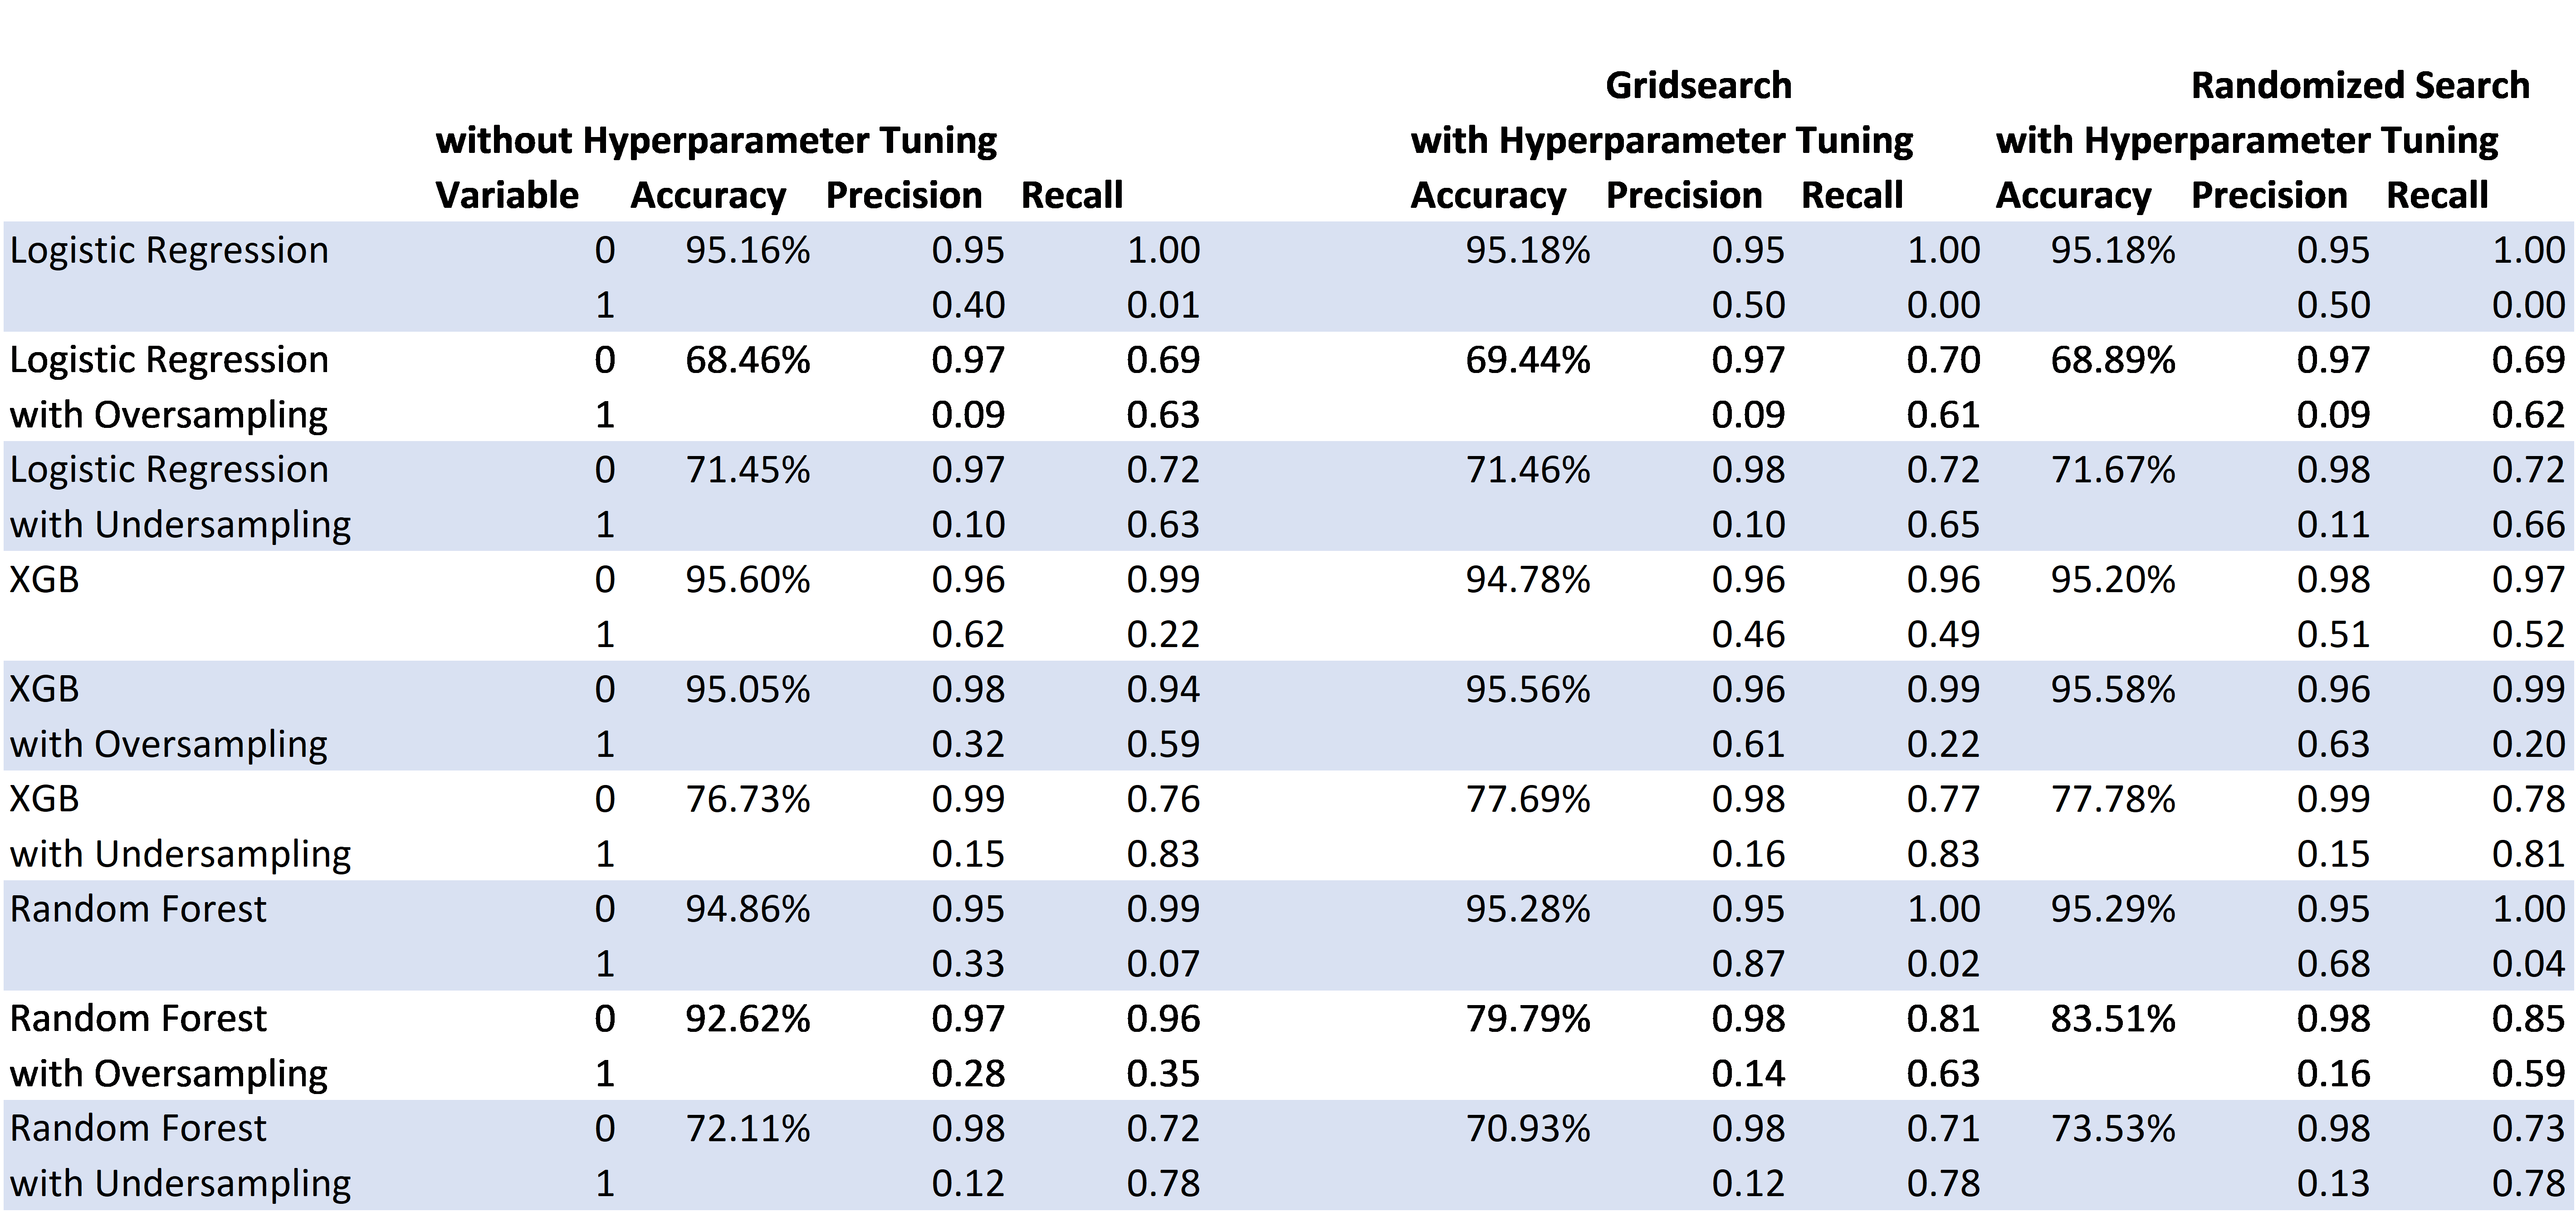

In [105]:
end = time.time()
print(end - start)

75457.15477442741


The best model for the bankruptcy class for recall is the XGB classifier with undersampled data and hyperparater tuning using GridSearch and the best model for precision was the Random Forest classifier with hyperparameter tuning on the original data  using Gridsearch.  The most balanced model on precision and recall is XGB on the original data with hyperparameter tuning using Randomized Search.  In the next section I will investigate feature importance and impact using those models.  

## Feature Importance

In [106]:
# print column names for feature importance
print(X_train.columns)

Index(['X02', 'X03', 'X04', 'X08', 'X09', 'X10', 'X11', 'X12', 'X13', 'X14',
       'X18', 'X19', 'X20', 'X22', 'X23', 'X24', 'X25', 'X26', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X43', 'X44', 'X48', 'X49', 'X50',
       'X51', 'X53', 'X54', 'X56', 'X58', 'X62', 'X63', 'X64', 'Year'],
      dtype='object')


X24     0.066415
X26     0.055667
X35     0.054082
X22     0.048774
X48     0.040592
X25     0.036573
X13     0.035817
X34     0.033902
X51     0.031230
X11     0.030857
X58     0.029678
X14     0.028334
X49     0.025472
X56     0.025272
X31     0.025111
X03     0.022068
X09     0.021827
X19     0.021631
X20     0.021356
Year    0.020921
X04     0.020319
X54     0.020127
X63     0.020045
X53     0.019894
X64     0.019892
X33     0.019804
X23     0.018959
X32     0.018804
X50     0.018413
X44     0.018381
X43     0.017735
X30     0.016796
X36     0.016796
X02     0.016722
X08     0.016504
X62     0.016168
X12     0.015026
X10     0.014036
X18     0.000000
dtype: float32


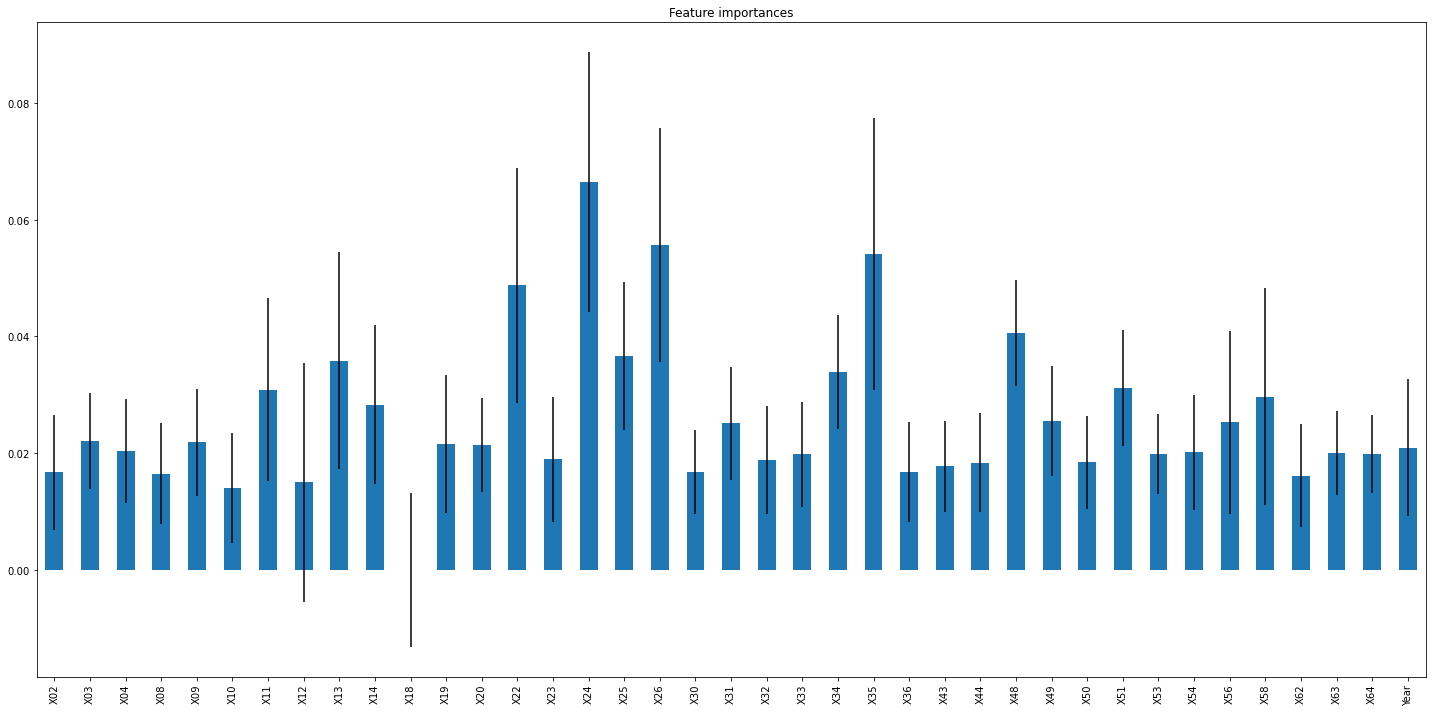

In [152]:
importances1 = CV_xgb6.feature_importances_
#std = np.std([tree.feature_importances_ for tree in CV_xgb6.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=feature_names)
print (forest_importances1.sort_values(ascending=False))
fig, ax = plt.subplots(1,1,figsize=(20,10) )
forest_importances1.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

X24     0.066327
X35     0.052012
X58     0.043672
X22     0.037926
X56     0.037348
X26     0.033959
X13     0.031401
Year    0.030945
X34     0.030371
X25     0.029419
X12     0.027361
X11     0.025544
X54     0.024324
X48     0.024201
X14     0.023014
X09     0.022534
X51     0.022352
X44     0.022229
X49     0.022077
X04     0.021596
X18     0.021552
X10     0.021480
X31     0.021414
X36     0.021243
X23     0.020999
X20     0.020821
X03     0.020656
X19     0.020446
X32     0.020152
X02     0.019916
X08     0.019755
X33     0.019433
X62     0.018909
X43     0.017986
X53     0.017972
X63     0.017653
X50     0.017498
X64     0.017078
X30     0.016424
dtype: float64


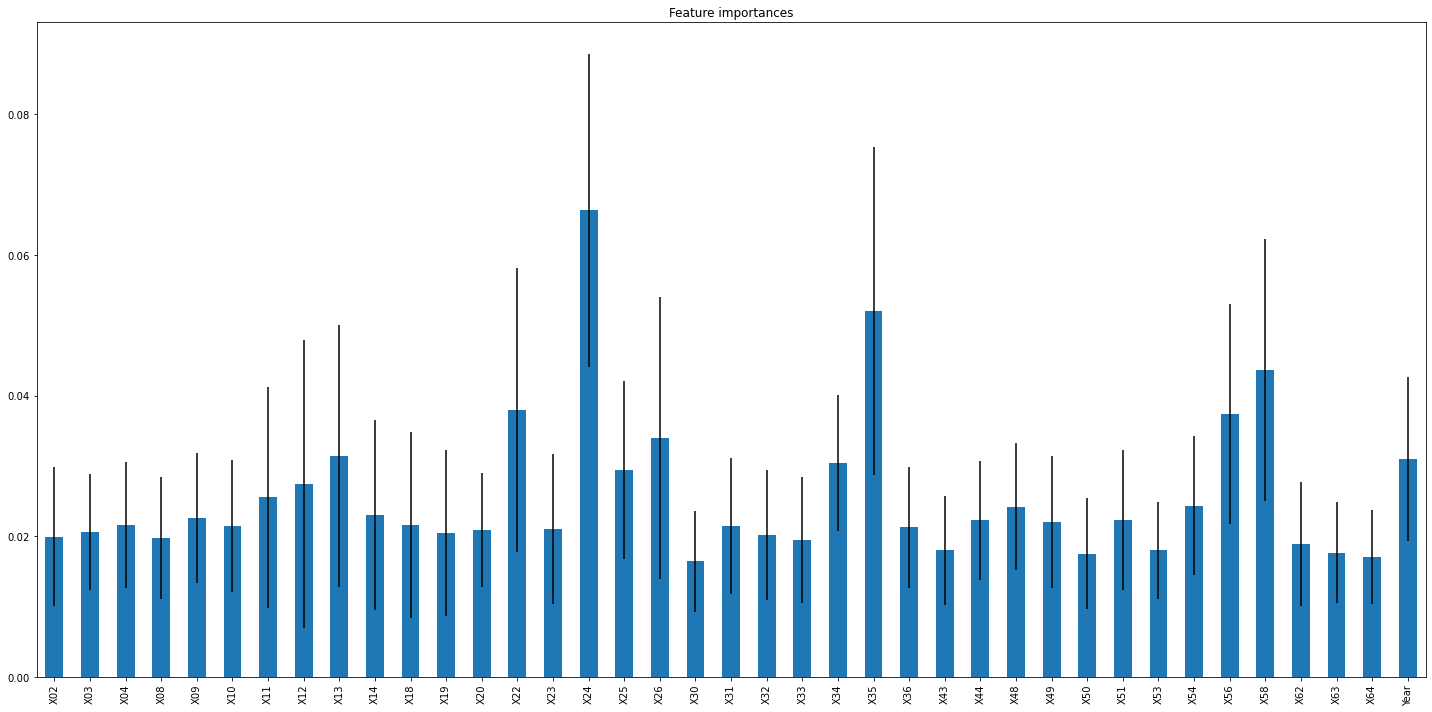

In [148]:
importances2 = CV_rfc4.feature_importances_
#std = np.std([tree.feature_importances_ for tree in CV_xgb6.estimators_], axis=0)

forest_importances2 = pd.Series(importances2, index=feature_names)
print (forest_importances2.sort_values(ascending=False))
fig, ax = plt.subplots(1,1,figsize=(20,10) )
forest_importances2.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

X26     0.092154
X24     0.075119
X22     0.058737
X34     0.041312
X35     0.039972
X25     0.034834
X14     0.031993
X19     0.030811
X13     0.030511
X11     0.030454
X58     0.030404
X48     0.026470
X32     0.026258
X56     0.024302
Year    0.024298
X51     0.024121
X09     0.022033
X64     0.021932
X31     0.019714
X33     0.019678
X36     0.019468
X23     0.019348
X20     0.019264
X49     0.017685
X44     0.017015
X02     0.017011
X62     0.016448
X53     0.016398
X50     0.016121
X12     0.015865
X08     0.015704
X63     0.015169
X30     0.015159
X54     0.014957
X03     0.014268
X04     0.013786
X43     0.013369
X10     0.011984
X18     0.005872
dtype: float32


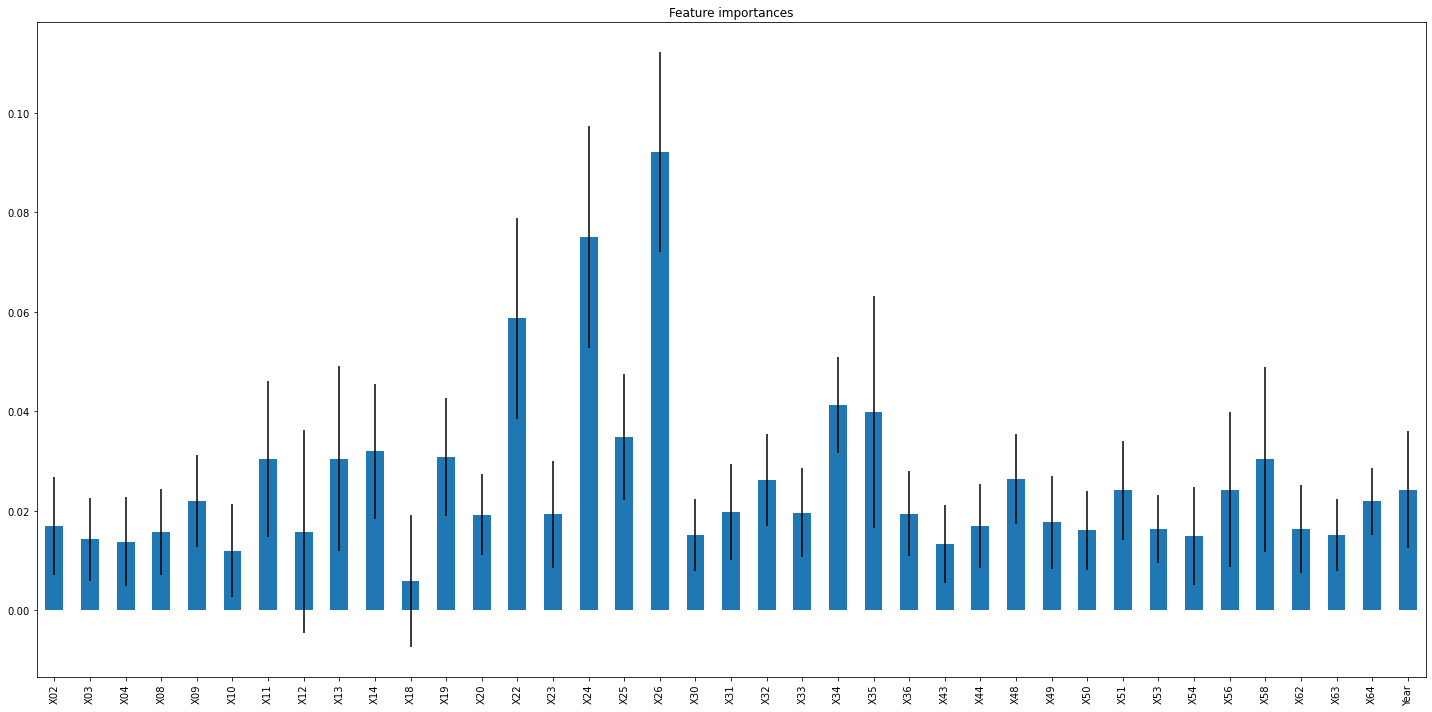

In [149]:
importances3 = CV_xgb4.feature_importances_
#std = np.std([tree.feature_importances_ for tree in CV_xgb6.estimators_], axis=0)

forest_importances3 = pd.Series(importances3, index=feature_names)
print (forest_importances3.sort_values(ascending=False))
fig, ax = plt.subplots(1,1,figsize=(20,10) )
forest_importances3.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


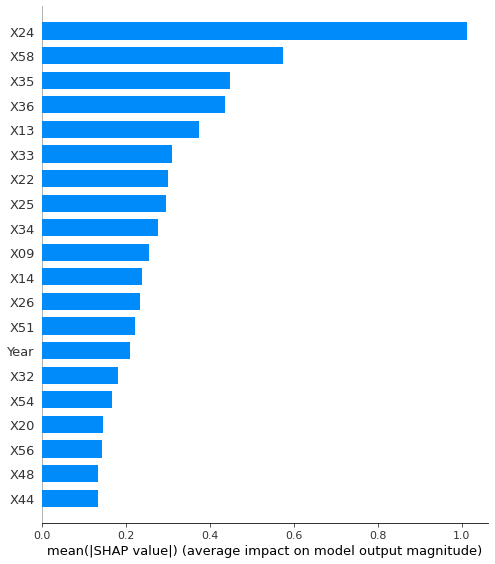

In [137]:
explainer = shap.TreeExplainer(CV_xgb6)
shap_values = explainer.shap_values(X_test)

shap.summary_plot( shap_values,X_test, plot_type="bar")

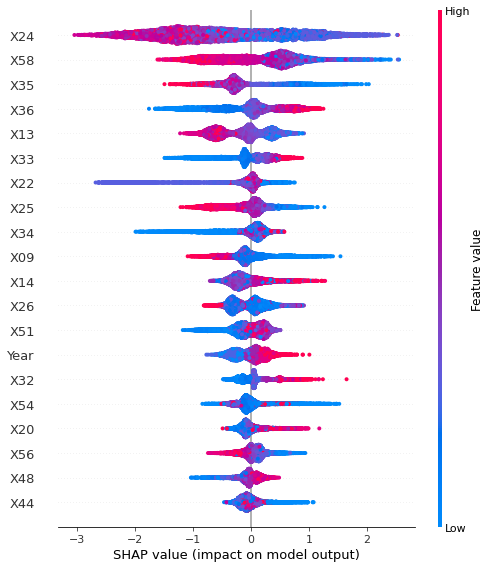

In [150]:
shap.summary_plot(shap_values, X_test)

...
column_dictionary = {
    
    "Variable" : "Ratio",
    "X01" : "net profit / total assets",
    "X02" : "total liabilities / total assets",
    "X03" : "working capital / total assets",
    "X04" : "current assets / short-term liabilities",
    "X05" : "[(cash + short-term securities + receivables-short-term liabilities)/(operating expenses - depreciation)]*365",
    "X06" : "retained earnings / total assets",
    "X07" : "EBIT / total assets",
    "X08" : "book value of equity / total liabilities",
    "X09"  : "sales / total assets",
    "X10" : "equity / total assets",
    "X11" : "(gross profit + extraordinary items + financial expenses) / total assets",
    "X12" : "gross profit / short-term liabilities",
    "X13" : "(gross profit + depreciation) / sales",
    "X14" : "(gross profit + interest) / total assets",
    "X15" : "(total liabilities * 365) / (gross profit + depreciation)",
    "X16" : "(gross profit + depreciation) / total liabilities",
    "X17" : "total assets / total liabilities",
    "X18" : "gross profit / total assets",
    "X19" : "gross profit / sales",
    "X20" : "(inventory * 365) / sales",
    "X21" : "sales (n) / sales (n-1)",
    "X22" : "profit on operating activities / total assets",
    "X23" : "net profit / sales",
    "X24" : "gross profit (in 3 years) / total assets",
    "X25" : "(equity - share capital) / total assets",
    "X26" : "(net profit + depreciation) / total liabilities",
    "X27" : "profit on operating activities / financial expenses",
    "X28" : "working capital / fixed assets",
    "X29" : "logarithm of total assets",
    "X30" : "(total liabilities - cash) / sales",
    "X31" : "(gross profit + interest) / sales",
    "X32" : "(current liabilities * 365) / cost of products sold",
    "X33" : "operating expenses / short-term liabilities",
    "X34" : "operating expenses / total liabilities",
    "X35"  : "profit on sales / total assets",
    "X36" : "total sales / total assets",
    "X37" : "(current assets - inventories) / long-term liabilities",
    "X38" : "constant capital / total assets",
    "X39" : "profit on sales / sales",
    "X40" : "(current assets - inventory - receivables) / short-term liabilities",
    "X41" : "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
    "X42" : "profit on operating activities / sales",
    "X43" : "rotation receivables + inventory turnover in days",
    "X44" : "(receivables * 365) / sales",
    "X45" : "net profit / inventory",
    "X46" : "(current assets - inventory) / short-term liabilities",
    "X47" : "(inventory * 365) / cost of products sold",
    "X48" : "EBITDA (profit on operating activities - depreciation) / total assets",
    "X49" : "EBITDA (profit on operating activities - depreciation) / sales",
    "X50" : "current assets / total liabilities",
    "X51" : "short-term liabilities / total assets",
    "X52" : "(short-term liabilities * 365) / cost of products sold)",
    "X53" : "equity / fixed assets",
    "X54" : "constant capital / fixed assets",
    "X55" : "working capital",
    "X56" : "(sales - cost of products sold) / sales",
    "X57" : "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
    "X58" : "total costs /total sales",
    "X59" : "long-term liabilities / equity",
    "X60" : "sales / inventory",
    "X61" : "sales / receivables",
    "X62" : "(short-term liabilities *365) / sales",
    "X63" : "sales / short-term liabilities",
    "X64" : "sales / fixed assets",
    "X65" : "bankrupt = 1"
 ...